# Big Data Mart
Problem Statement: The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.


Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

The dataset includes two files:
bigdatamart_Train.csv: Use this file for the model building purpose.
bigdatamart_Test.csv: Use this file for getting predictions from the trained model.

In [10]:
# importing  importent  libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import pickle
from joblib import dump, load

In [11]:
# Loading training data
train=pd.read_csv("https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Train.csv")
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [12]:
# loading testing data
test=pd.read_csv("https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Test.csv")
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [13]:
#checking shape of training and testing data
print('shape of traing data :-',train.shape)
print('shape of testing data :-',test.shape)

shape of traing data :- (8523, 12)
shape of testing data :- (5681, 11)


##### Training data contains 'Item_Outlet_Sales' , which contain sales from diffrent outlet.
##### Trainig have 12 columns whereas testing have 11.
##### Since sales is a continous value it makes this to be a Regression problem.

## Exploratory Data Analysis

In [14]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

The list of all the column names and a short description about it.

Item_Identifier: Unique Product ID
Item_Weight: Weight of product in grams
Item_Fat_Content: Whether the product is low fat or not
Item_Visibility: The percentage of total display area of all products in a store allocated to that particular product
Item_Type: The category in which the product belongs
Item_MRP: Maximum Retail Price (list price) of the product
Outlet_Identifier: Unique Store ID
Outlet_Establishment_Year: The year in which store was established
Outlet_Size: The size of the store in terms of ground area coverage
Outlet_Location_Type: The type of city in which the store is located
Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales: Sales of the product in the particulat store. This is the Outcome/Target data to be predicted.

In [15]:
# checking stats
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [16]:
# from stats we can determine column with name 'Item_Weight' contain null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [17]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

This show column with name 'Item_Weight' and 'Outlet_Size' have null value so we have to treat this ,
   and many column are object data type so we have to treat them too

In [18]:
#Let's check coloumns uniqueness :

for i in train.columns:
    print (i,':',len(train[i].unique()))

Item_Identifier : 1559
Item_Weight : 416
Item_Fat_Content : 5
Item_Visibility : 7880
Item_Type : 16
Item_MRP : 5938
Outlet_Identifier : 10
Outlet_Establishment_Year : 9
Outlet_Size : 4
Outlet_Location_Type : 3
Outlet_Type : 4
Item_Outlet_Sales : 3493


In [19]:
obj = []
for x in train.dtypes.index:
    if train.dtypes[x] == 'object':
        obj.append(x)
        
obj.remove('Item_Identifier')
obj.remove('Outlet_Identifier')    

obj

#We have listed down all the columns that have object data type and removed the columns 

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [20]:
for col in obj:
    print(col)
    print(train[col].value_counts())
    print("*"*40)

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
****************************************
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
****************************************
Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
****************************************
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64
***************************

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


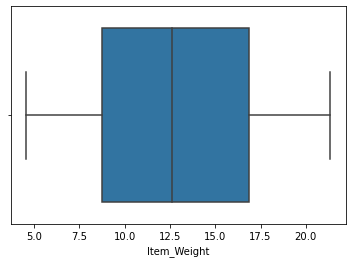

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


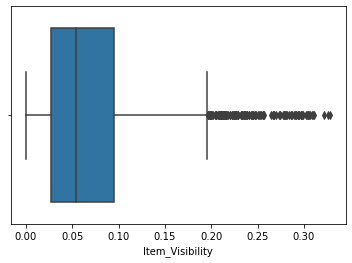

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


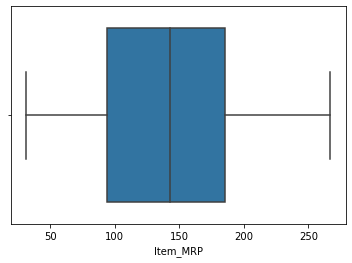

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


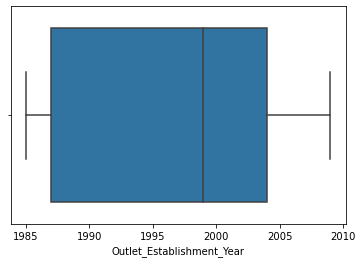

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


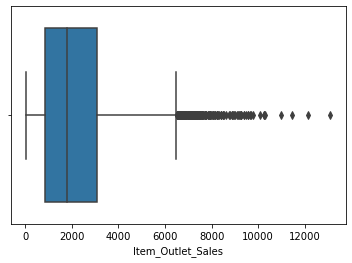

In [21]:
# visualising contineous data
for i in train.describe().columns:
    sns.boxplot(train[i].dropna())
    plt.show()
    

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


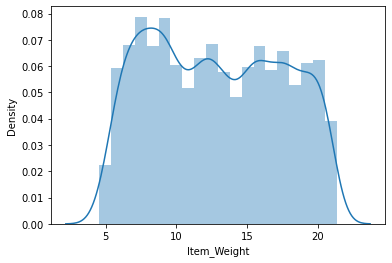

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


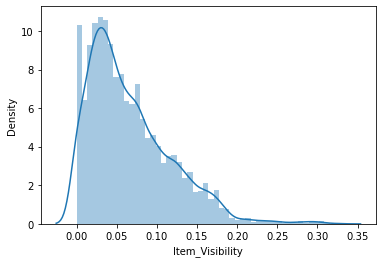

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


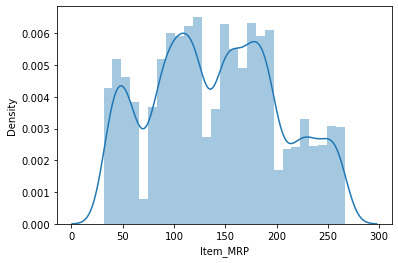

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


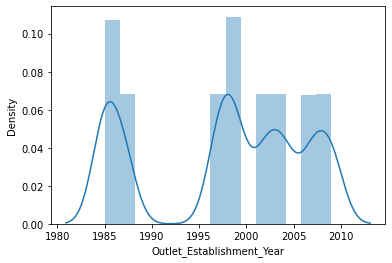

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


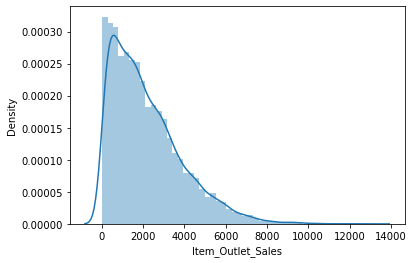

In [22]:
for i in train.describe().columns:
    sns.distplot(train[i].dropna())
    plt.show()
    

In [23]:
train['Item_Weight'].mean()

12.857645184136183

In [24]:
# Replacing null values with mean
train['Item_Weight'].fillna(train['Item_Weight'].mean(),inplace=True)

In [25]:
train['Item_Weight'].isnull().sum()

0

In [26]:
# Null value has been treated for column = ['Item_Weight']
 # for column = [" Outlet_Size"]
outlet_size_mode = train.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
outlet_size_mode


Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [27]:
missing_val = train['Outlet_Size'].isnull()
train.loc[missing_val, 'Outlet_Size'] = train.loc[missing_val, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [28]:
train['Outlet_Size'].isnull().sum()

0

In [29]:
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [30]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [31]:
train[train['Item_Visibility']==0]['Item_Visibility'].value_counts()

0.0    526
Name: Item_Visibility, dtype: int64

In [32]:
# it contains 526 '0' , so we should treat it,since its rightbskeewed we cant use mean , so we'lll use median
train.loc[:, 'Item_Visibility'].replace([0], [train['Item_Visibility'].median()], inplace=True)

In [33]:
train[train['Item_Visibility']==0]['Item_Visibility'].value_counts()

Series([], Name: Item_Visibility, dtype: int64)

In [34]:
# creating new column  outlet_year which will help us determine how old the outlet is
train['Outlet_Years'] = 2013 - train['Outlet_Establishment_Year']
train['Outlet_Years'].head()

0    14
1     4
2    14
3    15
4    26
Name: Outlet_Years, dtype: int64

In [35]:
# droping column = 'Outlet_Establishment_Year' since now its of no use
train = train.drop("Outlet_Establishment_Year", axis=1)
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FDX07,19.20,Regular,0.053931,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,15
4,NCD19,8.93,Low Fat,0.053931,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26


In [36]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
train['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [37]:
# Adding more columns/categories from the existing one's

train['New_Item_Type'] = train['Item_Identifier'].apply(lambda x: x[:2]) #for fetch first 2 alphabets
train['New_Item_Type'] = train['New_Item_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
train['New_Item_Type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: New_Item_Type, dtype: int64

In [38]:
train.loc[train['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
train['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

### Data Visualization

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


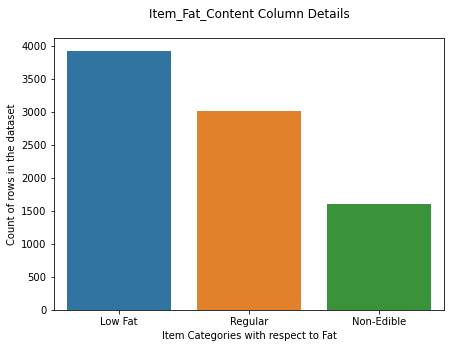

In [39]:
plt.figure(figsize=(7,5))
sns.countplot(train["Item_Fat_Content"])
plt.ylabel("Count of rows in the dataset")
plt.xlabel("Item Categories with respect to Fat")
plt.title("Item_Fat_Content Column Details\n")
plt.show()

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


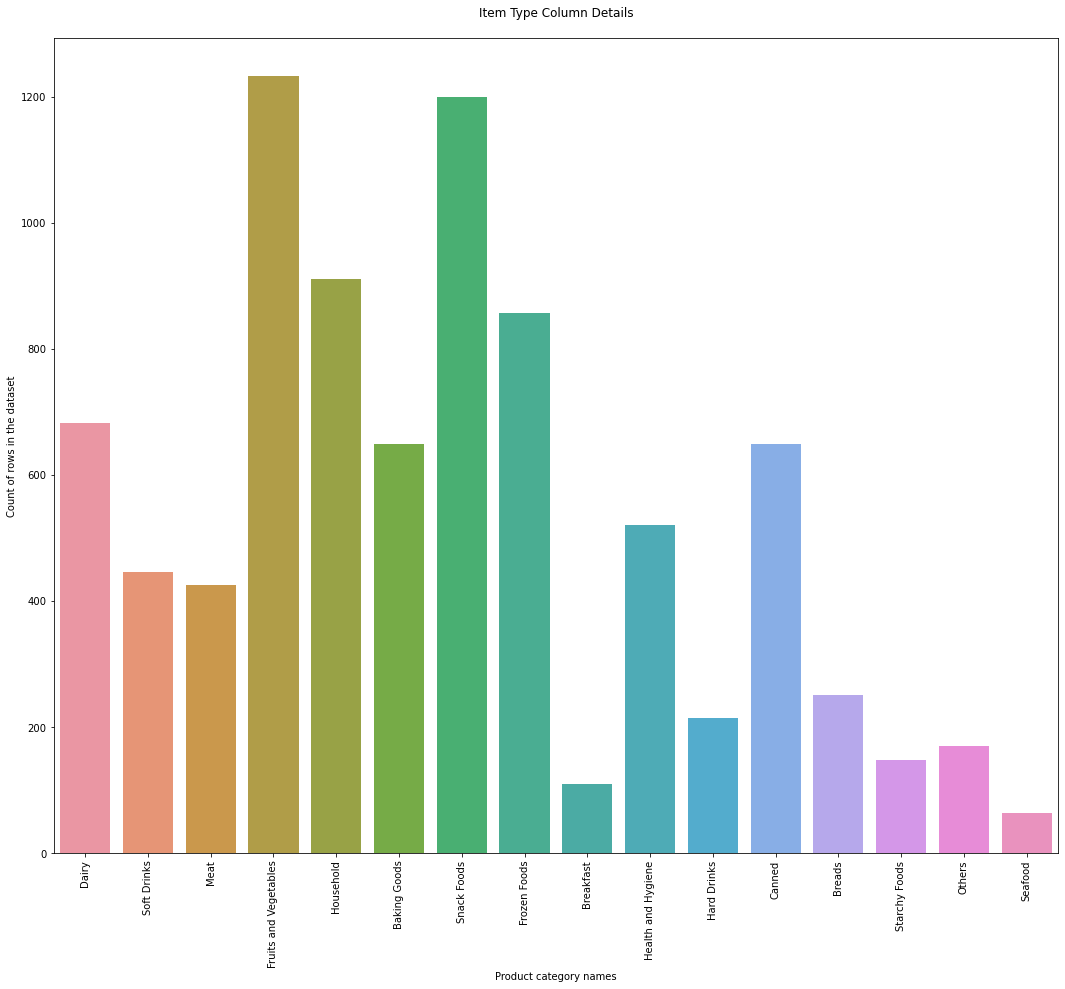

In [40]:
plt.figure(figsize=(18,15))
values = list(train['Item_Type'].unique())
diag = sns.countplot(train["Item_Type"])
diag.set_xticklabels(labels=values, rotation=90)
plt.title("Item Type Column Details\n")
plt.xlabel("Product category names")
plt.ylabel("Count of rows in the dataset")
plt.show()

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


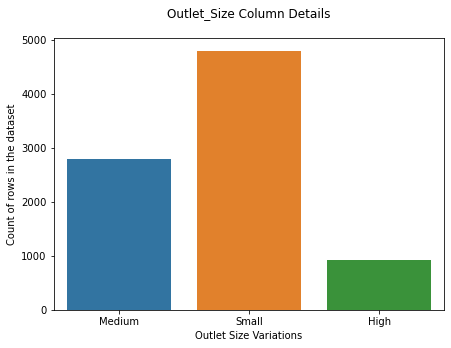

In [41]:
plt.figure(figsize=(7,5))
sns.countplot(train["Outlet_Size"])
plt.ylabel("Count of rows in the dataset")
plt.xlabel("Outlet Size Variations")
plt.title("Outlet_Size Column Details\n")
plt.show()

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


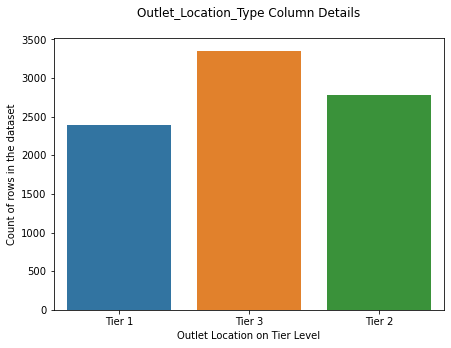

In [42]:
plt.figure(figsize=(7,5))
sns.countplot(train["Outlet_Location_Type"])
plt.ylabel("Count of rows in the dataset")
plt.xlabel("Outlet Location on Tier Level")
plt.title("Outlet_Location_Type Column Details\n")
plt.show()

/Users/shubh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


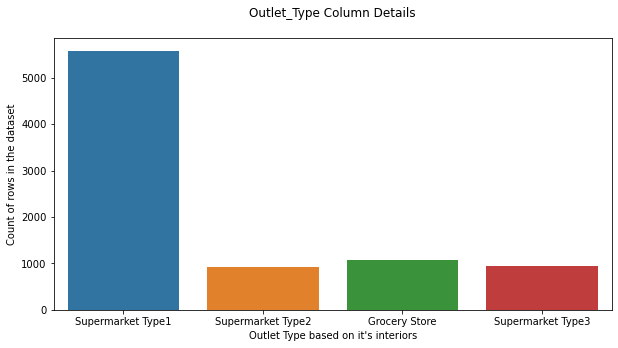

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(train["Outlet_Type"])
plt.ylabel("Count of rows in the dataset")
plt.xlabel("Outlet Type based on it's interiors")
plt.title("Outlet_Type Column Details\n")
plt.show()

## Correlation

<AxesSubplot:>

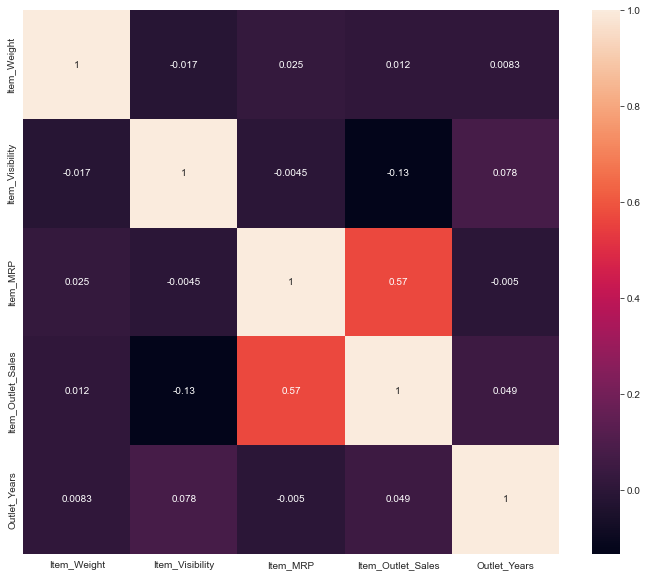

In [44]:
# finding correlation if any
#HeatMap and Correlation

sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
corr = train.corr()
sns.heatmap(corr, annot=True)

In [45]:
# log transformation on "Item_Outlet_Sales" column

train['Item_Outlet_Sales'] = np.log(1+train['Item_Outlet_Sales'])

### Encoding

In [46]:
train = train.drop(["Item_Identifier","Outlet_Identifier"], axis=1)
# Before applying any encoding method I have removing the columns Item_Identifier and Outlet_Identifier as they were just providing the ID informationlb=LabelEncoder()

In [47]:
lb=LabelEncoder()
col_name = ["Item_Type"]
for col in col_name:
    train[col] = lb.fit_transform(train[col])

In [48]:
# get_dummies create different column for diffrent category in single column
train = pd.get_dummies(train, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type'])


In [49]:
train.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Item_Outlet_Sales,Outlet_Years,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Size_High,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,New_Item_Type_Drinks,New_Item_Type_Food,New_Item_Type_Non-Consumable
0,9.30,0.016047,4,249.8092,8.225808,14,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,5.92,0.019278,14,48.2692,6.096776,4,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
2,17.50,0.016760,10,141.6180,7.648868,14,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,19.20,0.053931,6,182.0950,6.597664,15,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,8.93,0.053931,9,53.8614,6.903451,26,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1


### MODEL INSTANTIATION AND TRAINING

In [50]:
X = train.drop('Item_Outlet_Sales', axis=1)
Y = train['Item_Outlet_Sales']
#Separated the dataset into features and labels where X represents all the feature columns and Y represents the target label colum

In [51]:
#Scaling Feature dataset
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [52]:
#Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=111)
# Regression Model Function

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=111)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)

In [53]:
#Support Vector Regression
from sklearn.svm import SVR
model=SVR(C=1.0, epsilon=0.2, kernel='poly', gamma='auto')
reg(model, X, Y)

RMSE Score is: 0.5543307893822464
R2 Score is: 70.74985490717425
Cross Validation Score: 70.65528469330384
R2 Score - Cross Validation Score is 0.09457021387041209


In [54]:
# Decision Tree Regressor

model=DecisionTreeRegressor(criterion="poisson", random_state=111)
reg(model, X, Y)

RMSE Score is: 0.7746463178606862
R2 Score is: 42.878849835278196
Cross Validation Score: 43.6301806513134
R2 Score - Cross Validation Score is -0.7513308160352068


In [55]:
# Random Forest Regressor

model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 0.7745991402622743
R2 Score is: 42.88580722101794
Cross Validation Score: 45.81762586514581
R2 Score - Cross Validation Score is -2.9318186441278655


In [56]:
# K Neighbors Regressor

KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 0.7524645855815245
R2 Score is: 46.103302895767
Cross Validation Score: 45.777063803179395
R2 Score - Cross Validation Score is 0.3262390925876062


In [57]:
# Gradient Boosting Regressor

model=GradientBoostingRegressor(loss='quantile', n_estimators=200, max_depth=5)
reg(model, X, Y)

RMSE Score is: 0.7907342697661003
R2 Score is: 40.481614199970295
Cross Validation Score: 40.15374512785742
R2 Score - Cross Validation Score is 0.3278690721128754


In [58]:
# Choosing Support Vector Regression

fmod_param = {'kernel' : ["linear", "rbf"],
              'gamma' : ["scale", "auto"],
              'C' : [2.0, 4.0],
              'epsilon' : [0.2, 0.4]
             }
GSCV = GridSearchCV(SVR(), fmod_param, cv=5)

In [59]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [2.0, 4.0], 'epsilon': [0.2, 0.4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [60]:
GSCV.best_params_

{'C': 2.0, 'epsilon': 0.4, 'gamma': 'auto', 'kernel': 'rbf'}

In [61]:
Final_Model = SVR(C=2.0, epsilon=0.4, gamma="auto", kernel="rbf")
Model_Training = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred, multioutput='variance_weighted')*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: 72.66989113521205


## Pre processing the Testing Dataset to predict the Sales column

In [62]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [63]:

# Replacing null values with mean
test['Item_Weight'].fillna(test['Item_Weight'].mean(),inplace=True)# Null value has been treated for column = ['Item_Weight']
 
# for column = [" Outlet_Size"]           treating null value
outlet_size_mode = test.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
outlet_size_mode
missing_val = test['Outlet_Size'].isnull()
test.loc[missing_val, 'Outlet_Size'] = test.loc[missing_val, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

# item_visibility contains 526 '0' , so we should treat it,since its rightbskeewed we cant use mean , so we'lll use median
test.loc[:, 'Item_Visibility'].replace([0], [test['Item_Visibility'].median()], inplace=True)


# creating new column  outlet_year which will help us determine how old the outlet is
test['Outlet_Years'] = 2013 - test['Outlet_Establishment_Year']
test['Outlet_Years'].head()
# droping column = 'Outlet_Establishment_Year' since now its of no use
test = test.drop("Outlet_Establishment_Year", axis=1)


# changing lf,low fat to Low Fat and reg to Regular
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

# feature engineering ['New_Item_Type']
test['New_Item_Type'] = test['Item_Identifier'].apply(lambda x: x[:2]) #for fetch first 2 alphabets
test['New_Item_Type'] = test['New_Item_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

## feature engineering ['New_Item_Type']
test.loc[test['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

In [64]:
test = test.drop(["Item_Identifier","Outlet_Identifier"], axis=1)
# Before applying any encoding method I have removing the columns Item_Identifier and Outlet_Identifier as they were just providing the ID informationlb=LabelEncoder()
# encoding
lb=LabelEncoder()
col_name = ["Item_Type"]
for col in col_name:
    test[col] = lb.fit_transform(test[col])
    
# get_dummies create different column for diffrent category in single column
test = pd.get_dummies(test, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type'])
  

In [65]:
# Feature Scaling on all testing dataset rows

scaler = StandardScaler()
test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

In [66]:
test.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Years,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Size_High,Outlet_Size_Medium,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,New_Item_Type_Drinks,New_Item_Type_Food,New_Item_Type_Non-Consumable
0,1.897460e+00,-1.266918,1.366916,-0.536555,-0.139891,1.095940,-0.486429,-0.740811,-0.350325,1.432138,...,1.602644,-0.696584,-0.804750,-0.381568,0.726900,-0.349374,-0.351274,-0.316748,0.627510,-0.486429
1,-1.035530e+00,-0.630969,-0.766450,-0.868937,-1.095512,-0.912459,-0.486429,1.349873,-0.350325,-0.698257,...,-0.623969,1.435578,-0.804750,-0.381568,0.726900,-0.349374,-0.351274,-0.316748,0.627510,-0.486429
2,4.486336e-01,0.629009,0.892835,1.629848,-0.020438,-0.912459,2.055799,-0.740811,-0.350325,-0.698257,...,-0.623969,-0.696584,1.242623,2.620767,-1.375706,-0.349374,-0.351274,-0.316748,-1.593601,2.055799
3,-1.267578e+00,-1.105708,1.366916,0.226697,-1.095512,1.095940,-0.486429,-0.740811,-0.350325,-0.698257,...,-0.623969,1.435578,-0.804750,-0.381568,0.726900,-0.349374,-0.351274,-0.316748,0.627510,-0.486429
4,-5.230960e-14,1.021020,-0.766450,1.508110,1.532446,-0.912459,-0.486429,1.349873,-0.350325,1.432138,...,-0.623969,-0.696584,1.242623,-0.381568,-1.375706,-0.349374,2.846782,-0.316748,0.627510,-0.486429


### Result Prediction

In [67]:
# Predicting the Item_Outlet_Sales from the feature columns of our Testing dataset

Predicted_Sales = Final_Model.predict(test)

In [68]:
# Reversing the Log Transformation that was performed on the Target column while training the ML Model

Predicted_Sales = np.exp(Predicted_Sales)
Predicted_Sales

array([1377.70220999, 1275.330638  ,  689.5820365 , ..., 1823.74740104,
       3952.85505423, 1042.05259037])

In [69]:
#Converting sales output back in csv format
predicted_output = pd.DataFrame()
predicted_output['Item_Outlet_Sales']=Predicted_Sales
predicted_output

,Item_Outlet_Sales
0,1377.702210
1,1275.330638
2,689.582037
3,2479.391812
4,5198.873569
...,...
5676,2232.892679
5677,2792.908874
5678,1823.747401
5679,3952.855054


In [70]:
predicted_output.to_csv("Predicted_Sales_Data.csv", index=False)

## Model Saving

In [71]:
from joblib import dump, load
import joblib
filename = "BigDataSales.pkl"
joblib.dump(Final_Model, filename)

['BigDataSales.pkl']